In [1]:
# Load packages for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load packages for Big Query 
from google.cloud import bigquery
import os

### Set-up

**Set-up: GCP interface** 

Run before querying to setup Big Query

In [2]:
# Define configurations for Big Query - Stride Datalake
project_id = 'som-nero-phi-boussard' # Location of stride datalake
db = "som-nero-phi-boussard.stride_datalake" # Define the database
msc = "som!-nero-phi-boussard.MSc_ACU_Oncology"
es = "som-nero-phi-boussard.ES_ACU_Oncology"
client = bigquery.Client(project=project_id) # Set project to project_id
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/eliasaquand/.config/gcloud/application_default_credentials.json'
os.environ['GCLOUD_PROJECT'] = "som-nero-phi-boussard" # specify environment
db = "som-nero-phi-boussard" # Define the database

/Users/eliasaquand/miniforge3/envs/env/lib/python3.9/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


**Set-up: GCP data table creation in Big Query**

In [3]:
# 1) Specify the job config to properly read the file
job_config = bigquery.LoadJobConfig()
job_config.autodetect = True # determines the datatype of the variable
job_config.write_disposition = 'WRITE_TRUNCATE'
job_config.max_bad_records = 1 # allow 5 bad records; 

# Read schema from JSON
# job_config.schema = self.bq_client.schema_from_json(
# f"{json_schema_dir}/{custom_mapping_table}.json")

# 2) Specify destination
# destination = f"som-nero-phi-boussard.MSc_ACU_Oncology.[COHORT NAME]"

# 3) Save file ob Big Query, using result from so far; client is specified above - implemented in the file 
# load_job = client.load_table_from_dataframe(dataframe = chemo_tx_dd,                                  
#                                                     destination = destination,
#                                                     job_config = job_config)

# Run the job:
# load_job.result()

**Get cohort patient table**

In [4]:
sql_query = f""" SELECT * FROM {es}.cohort_p1_text"""
cohort = (client.query(sql_query)).to_dataframe()

In [5]:
cohort

,PAT_DEID,HOSP_ADMSN_TIME,CHE_TX_DATE
0,1770802,2020-02-07 20:54:00,2020-01-16 00:00:00
1,3945576,2020-02-01 09:14:00,2020-01-24 00:00:00
2,1045640,2016-02-15 20:12:00,2016-02-08 00:00:00
3,1289918,2016-04-15 23:13:00,2016-03-16 00:00:00
4,2766580,2016-04-13 17:43:00,2016-03-24 00:00:00
...,...,...,...
1748,538184,2015-02-13 13:13:00,2015-01-16 08:59:00
1749,1253627,2019-03-14 16:38:00,2019-03-08 23:59:00
1750,3456627,2018-11-12 13:20:00,2018-10-17 09:59:00
1751,3316652,2014-06-06 19:31:00,2014-06-05 23:59:00


**Define new outcome tables**

TODO: Built the relevant outcome table with only the selected patient after filtering

### Build Patient Table 

In [6]:
# Load the note table 
#sql_query = f""" SELECT * FROM {es}.relevant_note_table"""
sql_query = f""" SELECT * FROM {es}.note_by_type"""
note_table  = (client.query(sql_query)).to_dataframe()

In [8]:
note_table.shape

(5002, 6)

In [34]:
patient_table = cohort["PAT_DEID"]

**Add note count per patient**

In [35]:
# Create column with the number of notes per patient
patient_table = pd.merge(patient_table, note_table.groupby(["PAT_DEID"], as_index=False)["PAT_DEID"].value_counts(), how='left', on="PAT_DEID")

In [36]:
patient_table.rename(columns={"count": "NOTE_COUNT"}, inplace=True)

**Add average word count in the notes per patient**

In [37]:
# Create column with the average word count in the notes per patient: SUM(WORD_COUNT)/ NOTE_COUNT)
patient_table = pd.merge(patient_table, note_table.groupby(["PAT_DEID"], as_index=False)["WORD_COUNT"].sum(), how='left', on="PAT_DEID")
patient_table["AVG_WORD_COUNT_NOTE"] = patient_table["WORD_COUNT"] / patient_table["NOTE_COUNT"] 
del patient_table["WORD_COUNT"]

In [38]:
patient_table

,PAT_DEID,NOTE_COUNT,AVG_WORD_COUNT_NOTE
0,1770802,2,2799.5
1,3945576,2,2795.0
2,1045640,2,2675.5
3,1289918,3,3020.333333
4,2766580,3,3338.666667
...,...,...,...
1748,538184,4,2845.25
1749,1253627,2,2308.5
1750,3456627,1,2014.0
1751,3316652,2,2890.5


**Add number of classes per patient**

In [39]:
# Load outcome_table_1 with a binary column for each class
sql_query = f""" SELECT * FROM {es}.outcome_table_1"""
outcome_table_1 = (client.query(sql_query)).to_dataframe()

In [40]:
outcome_table_1

,PAT_DEID,CLASS_1,CLASS_2,CLASS_3,CLASS_4,CLASSES,TOTAL
0,10789,1.0,1.0,0.0,0.0,"[class_1, class_2]",2.0
1,13408,1.0,1.0,0.0,0.0,"[class_1, class_2]",2.0
2,93047,1.0,1.0,0.0,0.0,"[class_1, class_2]",2.0
3,132939,1.0,1.0,0.0,0.0,"[class_1, class_2]",2.0
4,135150,1.0,1.0,0.0,0.0,"[class_1, class_2]",2.0
...,...,...,...,...,...,...,...
1748,4037090,0.0,0.0,0.0,1.0,[class_4],1.0
1749,4037662,0.0,0.0,0.0,1.0,[class_4],1.0
1750,4054999,0.0,0.0,0.0,1.0,[class_4],1.0
1751,4092738,0.0,0.0,0.0,1.0,[class_4],1.0


In [41]:
# Create column with the number of classes associated with each patient 
patient_table = pd.merge(patient_table, outcome_table_1[["PAT_DEID", "TOTAL"]], how='inner', on="PAT_DEID")
patient_table.rename(columns={"TOTAL": "CLASS_COUNT"}, inplace=True)

**Add number of distinct symtpom in each class per patient**

In [42]:
# Load outcome_table_2 with the number of distinct symtpom in each class
sql_query = f""" SELECT * FROM {es}.outcome_table_2"""
outcome_table_2 = (client.query(sql_query)).to_dataframe()

In [43]:
# Create column the number of distinct symptoms associated with each patient 
patient_table = pd.merge(patient_table, outcome_table_2[["PAT_DEID", "TOTAL"]], how='inner', on="PAT_DEID")
patient_table.rename(columns={"TOTAL": "DISTINCT_SYMPTOM_COUNT"}, inplace=True)

**Add number of AE occurence per patient**

In [44]:
# Load outcome_table_3 with a frequency column (# of AE occurence) column for each class
sql_query = f""" SELECT * FROM {es}.outcome_table_3"""
outcome_table_3 = (client.query(sql_query)).to_dataframe()

In [45]:
# Create column the number of symptoms associated with each patient 
patient_table = pd.merge(patient_table, outcome_table_3[["PAT_DEID", "TOTAL"]], how='inner', on="PAT_DEID")
patient_table.rename(columns={"TOTAL": "SYMPTOM_COUNT"}, inplace=True)

In [46]:
patient_table

,PAT_DEID,NOTE_COUNT,AVG_WORD_COUNT_NOTE,CLASS_COUNT,DISTINCT_SYMPTOM_COUNT,SYMPTOM_COUNT
0,1770802,2,2799.5,2.0,2.0,3.0
1,3945576,2,2795.0,2.0,2.0,3.0
2,1045640,2,2675.5,2.0,2.0,8.0
3,1289918,3,3020.333333,2.0,2.0,7.0
4,2766580,3,3338.666667,3.0,4.0,6.0
...,...,...,...,...,...,...
1748,538184,4,2845.25,2.0,2.0,4.0
1749,1253627,2,2308.5,3.0,4.0,8.0
1750,3456627,1,2014.0,1.0,1.0,2.0
1751,3316652,2,2890.5,2.0,3.0,9.0


In [47]:
# Save patient table with information on the patients 
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.patient_table"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = patient_table,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=f0953493-ea9b-4f7b-beb3-392b022c6997>

In [48]:
# Get the id of the patients that have more than or equal to 200 notes 
# patient_table[patient_table["NOTE_COUNT"] >= 200].PAT_DEID

### Build statistic table

In [49]:
stats_table = pd.DataFrame()

In [50]:
# Total number of patients
stats_table["PATIENT_COUNT"] = pd.Series(patient_table.shape[0])

In [51]:
# Total number of notes
stats_table["NOTE_COUNT"] = pd.Series(note_table.shape[0])

In [52]:
# Average number of note per patient AVG(NOTE_COUNT) calculated with the mean (sensitive to outliers)
stats_table["AVG_MEAN_NOTE_COUNT"] = patient_table["NOTE_COUNT"].mean()
# Average number of note per patient AVG(NOTE_COUNT) calculated with the median (not sensitive to outliers)
stats_table["AVG_MEDIAN_NOTE_COUNT"] = patient_table["NOTE_COUNT"].median()
# Minimum number of notes
stats_table["MIN_NOTE_COUNT"] = patient_table["NOTE_COUNT"].min()
# Max number of notes 
stats_table["MAX_NOTE_COUNT"] = patient_table["NOTE_COUNT"].max()

In [53]:
# Create column with the average of average word count in the notes per patient calculated with the mean
stats_table["AVG_MEAN_AVG_WORD_COUNT_NOTE"] = patient_table["AVG_WORD_COUNT_NOTE"].mean()
# Create column with the average of average word count in the messages per patient calculated with the median
stats_table["AVG_MEDIAN_AVG_WORD_COUNT_NOTE"] = patient_table["AVG_WORD_COUNT_NOTE"].median()
# Minimum avg word count in the messages
stats_table["MIN_AVG_WORD_COUNT_NOTE"] = patient_table["AVG_WORD_COUNT_NOTE"].min()
# Maximum avg word count in the messages
stats_table["MAX_AVG_WORD_COUNT_NOTE"] = patient_table["AVG_WORD_COUNT_NOTE"].max()

In [54]:
# Create column with the average number of classes per patient: MEAN(CLASS_COUNT) 
stats_table["AVG_MEAN_CLASS_COUNT"] = patient_table["CLASS_COUNT"].mean()
# Create column with the average number of classes per patient: MEDIAN(CLASS_COUNT)
stats_table["AVG_MEDIAN_CLASS_COUNT"] = patient_table["CLASS_COUNT"].median()
# Create column with the min number of classes per patient
stats_table["MIN_CLASS_COUNT"] = patient_table["CLASS_COUNT"].min()
# Create column with the max number of classes per patient
stats_table["MAX_CLASS_COUNT"] = patient_table["CLASS_COUNT"].max()

In [55]:
# Create column with the average number of AE per patient: MEAN(DISTINCT_SYMPTOM_COUNT)
stats_table["AVG_MEAN_DISTINCT_SYMPTOM_COUNT"] = patient_table["DISTINCT_SYMPTOM_COUNT"].mean()
# Create column with the average number of AE per patient: MEDIAN(DISTINCT_SYMPTOM_COUNT)
stats_table["AVG_MEDIAN_DISTINCT_SYMPTOM_COUNT"] = patient_table["DISTINCT_SYMPTOM_COUNT"].median()
# Create column with the min number of AE per patient
stats_table["MIN_DISTINCT_SYMPTOM_COUNT"] = patient_table["DISTINCT_SYMPTOM_COUNT"].min()
# Create column with the max number of AE per patient
stats_table["MAX_DISTINCT_SYMPTOM_COUNT"] = patient_table["DISTINCT_SYMPTOM_COUNT"].max()

In [56]:
# Create column with the average number of AE per patient: MEAN(SYMPTOM_COUNT)
stats_table["AVG_MEAN_SYMPTOM_COUNT"] = patient_table["SYMPTOM_COUNT"].mean()
# Create column with the average number of AE per patient: MEDIAN(SYMPTOM_COUNT)
stats_table["AVG_MEDIAN_SYMPTOM_COUNT"] = patient_table["SYMPTOM_COUNT"].median()
# Create column with the average number of AE per patient: MEDIAN(SYMPTOM_COUNT)
stats_table["MIN_SYMPTOM_COUNT"] = patient_table["SYMPTOM_COUNT"].min()
# Create column with the average number of AE per patient: MEDIAN(SYMPTOM_COUNT)
stats_table["MAX_SYMPTOM_COUNT"] = patient_table["SYMPTOM_COUNT"].max()

In [57]:
stats_table.MAX_AVG_WORD_COUNT_NOTE

0    7903.0
Name: MAX_AVG_WORD_COUNT_NOTE, dtype: float64

In [58]:
# Save patient table with information on the patients 
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.stats_table"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = stats_table,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=170e5857-6455-45d5-a51d-72b8996d153a>

In [59]:
stats_table.AVG_MEDIAN_CLASS_COUNT

0    2.0
Name: AVG_MEDIAN_CLASS_COUNT, dtype: float64

In [60]:
stats_table

,PATIENT_COUNT,NOTE_COUNT,AVG_MEAN_NOTE_COUNT,AVG_MEDIAN_NOTE_COUNT,MIN_NOTE_COUNT,MAX_NOTE_COUNT,AVG_MEAN_AVG_WORD_COUNT_NOTE,AVG_MEDIAN_AVG_WORD_COUNT_NOTE,MIN_AVG_WORD_COUNT_NOTE,MAX_AVG_WORD_COUNT_NOTE,...,MIN_CLASS_COUNT,MAX_CLASS_COUNT,AVG_MEAN_DISTINCT_SYMPTOM_COUNT,AVG_MEDIAN_DISTINCT_SYMPTOM_COUNT,MIN_DISTINCT_SYMPTOM_COUNT,MAX_DISTINCT_SYMPTOM_COUNT,AVG_MEAN_SYMPTOM_COUNT,AVG_MEDIAN_SYMPTOM_COUNT,MIN_SYMPTOM_COUNT,MAX_SYMPTOM_COUNT
0,1753,5002,2.853394,2.0,1,15,2297.050998,2256.0,304.0,7903.0,...,1.0,4.0,2.480319,2.0,1.0,8.0,6.219624,5.0,1.0,43.0


**Build histograms**

In [61]:
# Load patient table
#sql_query = f""" SELECT * FROM {es}.patient_table"""
#patient_table = (client.query(sql_query)).to_dataframe()
patient_table

,PAT_DEID,NOTE_COUNT,AVG_WORD_COUNT_NOTE,CLASS_COUNT,DISTINCT_SYMPTOM_COUNT,SYMPTOM_COUNT
0,1770802,2,2799.5,2.0,2.0,3.0
1,3945576,2,2795.0,2.0,2.0,3.0
2,1045640,2,2675.5,2.0,2.0,8.0
3,1289918,3,3020.333333,2.0,2.0,7.0
4,2766580,3,3338.666667,3.0,4.0,6.0
...,...,...,...,...,...,...
1748,538184,4,2845.25,2.0,2.0,4.0
1749,1253627,2,2308.5,3.0,4.0,8.0
1750,3456627,1,2014.0,1.0,1.0,2.0
1751,3316652,2,2890.5,2.0,3.0,9.0


In [62]:
patient_table['NOTE_COUNT'].value_counts()

2     595
1     376
4     306
3     212
5     129
6      76
7      29
8      15
10      6
9       6
15      1
11      1
12      1
Name: NOTE_COUNT, dtype: int64

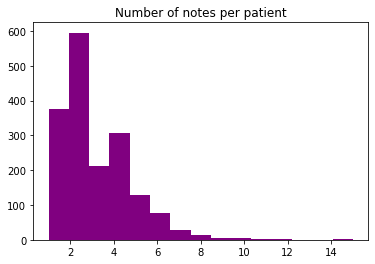

In [66]:
# Create histogram of the number of notes per patient 
patient_table['NOTE_COUNT'].hist(bins=15, grid=False, color = "purple",)
plt.title('Number of notes per patient')
plt.savefig("notes_per_patient.png")

In [67]:
patient_table.DISTINCT_SYMPTOM_COUNT.value_counts()

1.0    533
2.0    524
3.0    303
4.0    204
5.0    111
6.0     61
7.0     15
8.0      2
Name: DISTINCT_SYMPTOM_COUNT, dtype: int64

In [69]:
patient_table.CLASS_COUNT.value_counts()

2.0    673
1.0    659
3.0    318
4.0    103
Name: CLASS_COUNT, dtype: int64

In [68]:
patient_table

,PAT_DEID,NOTE_COUNT,AVG_WORD_COUNT_NOTE,CLASS_COUNT,DISTINCT_SYMPTOM_COUNT,SYMPTOM_COUNT
0,1770802,2,2799.5,2.0,2.0,3.0
1,3945576,2,2795.0,2.0,2.0,3.0
2,1045640,2,2675.5,2.0,2.0,8.0
3,1289918,3,3020.333333,2.0,2.0,7.0
4,2766580,3,3338.666667,3.0,4.0,6.0
...,...,...,...,...,...,...
1748,538184,4,2845.25,2.0,2.0,4.0
1749,1253627,2,2308.5,3.0,4.0,8.0
1750,3456627,1,2014.0,1.0,1.0,2.0
1751,3316652,2,2890.5,2.0,3.0,9.0
